# Notebook 2 - Working with Raster Data in GemGIS

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for a direct use in [GemPy](https://github.com/cgre-aachen/gempy). The package provides functions to process spatial data such as vector data (shape-files), raster data (tiff-files), data retrieved from WMS Services or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, chosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook will present how existing raster files can be loaded into GemGIS, how new raster files can be created and how to work with raster files in general. The main tool that is going to be used here is [rasterio](https://rasterio.readthedocs.io/en/latest/#).

- <a href='ex1'>Example 1 - Raster Data - Digital Elevation Model</a>
- <a href='ex2'>Example 2 - Raster Data - Interpolate Raster</a>

## What is raster data?

In its simplest form, a raster consists of a matrix of cells (or pixels) organized into rows and columns (or a grid) where each cell contains a value representing information, such as the height value. Rasters are digital aerial photographs, imagery from satellites, digital pictures, or even scanned maps.

<img src="../data/Images/raster.png" width=300>

- **Rasters as basemaps**: A common use of raster data in a GIS is as a background display for other feature layers.Three main sources of raster basemaps are orthophotos from aerial photography, satellite imagery, and scanned maps. 

- **Rasters as surface maps**: Rasters are well suited for representing data that changes continuously across a landscape (surface). Elevation values measured from the earth's surface are the most common application of surface maps, but other values, such as rainfall, temperature, concentration, and population density, can also define surfaces that can be spatially analyzed.

- **Rasters as thematic maps**: Rasters representing thematic data can be derived from analyzing other data. A common analysis application is classifying a satellite image by land-cover categories. For example, you can process data through a geoprocessing model to create a raster dataset that maps suitability for a specific activity.

Source: https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/what-is-raster-data.htm

## What is rasterio?

Rasterio reads and writes geospatial raster datasets. Rasterio employs [GDAL](https://gdal.org/) under the hood for file I/O and raster formatting. Its functions typically accept and return Numpy ndarrays. Rasterio is designed to make working with geospatial raster data more productive and more fun.

For more information see: https://pypi.org/project/rasterio/0.13.2/, https://rasterio.readthedocs.io/en/latest/

## What is GemPy?

`GemPy` is a Python-based, **open-source geomodeling library**. It is
capable of constructing complex **3D geological models** of folded
structures, fault networks and unconformities, based on the underlying
powerful **implicit representation** approach. `GemPy` was designed from the
ground up to support easy embedding in probabilistic frameworks for the
uncertainty analysis of subsurface structures.

Check out the documentation either on the main website (https://www.gempy.org/) or the specific docs site (http://docs.gempy.org/).

- GemPy Installation Help: https://docs.gempy.org/installation.html
- GemPy Tutorials: https://docs.gempy.org/tutorials/index.html
- GemPy Examples: https://docs.gempy.org/examples/index.html
- GemPy Repository: https://github.com/cgre-aachen/gempy

## Downloading and installing GemGIS

GemGIS is currently under development and only available at https://github.com/cgre-aachen/gemgis. pip and conda versions including a documentation page will follow.

If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 


# Importing Libraries

Apart from creating a GemPyData class in later tutorials, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.6.1 is the latest stable version that is supported by GemGIS***. An introduction to working with GeoPandas was provided in the previous notebook.

In [1]:
import sys
sys.path.append('../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Version Reports
Reporting your Python environment's package versions and hardware resources by Scooby - https://github.com/banesullivan/scooby. This overview shows the packages and their versions used to run this notebook. Up- or downgrading to older or newer versions may break the notebook.

In [2]:
gg.Report()

--------------------------------------------------------------------------------
  Date: Sat Jul 18 21:35:06 2020 W. Europe Daylight Time

                OS : Windows
            CPU(s) : 24
           Machine : AMD64
      Architecture : 64bit
               RAM : 63.9 GB
       Environment : Jupyter

  Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]

              json : 2.0.9
             numpy : 1.18.5
            scooby : 0.5.2
            owslib : 0.17.0
            pandas : 1.0.5
           shapely : 1.6.4.post1
           pyvista : 0.25.3
          rasterio : 1.0.21
         geopandas : 0.6.1
          requests : 2.24.0
             scipy : 1.5.0
        matplotlib : 3.2.2

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

<a id='ex1'></a>
# Example 1 - Raster Data - Digital Elevation Model

As a first example we will have a look at a geological map as shown below. The gray southward dipping layer is surrounded by two white layers. The topography decreases from north to south. A raster file ```raster1.tif``` containing the altitude values was created externally. This data can now be loaded and plotted as shown below. The strength of GemGIS is it that it is working with pure rasterio objects providing you with their full range of functionality.

**What is a Rasterio Object?**
Opening a raster with Rasterio will create a rasterio object containing different attributes such as the raster values, the CRS, the transform and others. 

For more information see: https://rasterio.readthedocs.io/en/latest/quickstart.html#dataset-attributes

**What is a coordinate reference system?**<br>
The Coordinate Reference System (CRS) is important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth.

For more information see: https://geopandas.org/projections.html and https://spatialreference.org/ for codes for most commonly used projections.

For the tutorials `EPSG:4326`(WGS84 latitude-longitude projection) is used. It ranges from -180 to 180 degrees (longitude) and -90 to 90 degrees (latitude). For simplicity it is assumed that the units are meters and not degrees. This implies that the extent of the examples does not relate to the real world but a CRS is needed for transformation purposes. 


For this example we will use the following functions:

- `gg.interpolate_raster(...)`


<img src="../data/Test1/task1.png" width="300">

## Loading data

TThe raster data will be loaded as rasterio.io.DataSetReader object. The data is provided in the [repository](https://github.com/cgre-aachen/gemgis). The coordinate reference system (CRS) is stored within the object which is essential to know when transforming data from one CRS to another. 

In [3]:
dem = rasterio.open('../../gemgis/data/Test1/raster1.tif')
geological_map = rasterio.open('../../gemgis/data/Test1/task1.tif')

## Defining the working/model area extent

Especially when working with unreferenced numpy.ndarrays, it becomes important to provide the extent of these arrays in real world coordinates. The extent can be provided for GemGIS as ```minx, maxx, miny, maxy``` and if a third dimension is available as ```minx, maxx, miny, maxy, minz, maxz```.

In [4]:
extent = gg.set_extent(0,972,0,1069)
extent

[0, 972, 0, 1069]

## Plotting Data

The raster data can now be plotted next to the geological map without any manipulation by using ```plt.imshow(...)```. Bright values indicate high altitudes, dark colors indicate low altitudes. When plotting the raster it is necessary to provide the extent of the raster as defined above. This way, the raster is scaled to the true extent of the geological map. A second important thing is that the height values of the object can be accessed with ```dem.read(1)``` where 1 is equal to the band number of the raster.

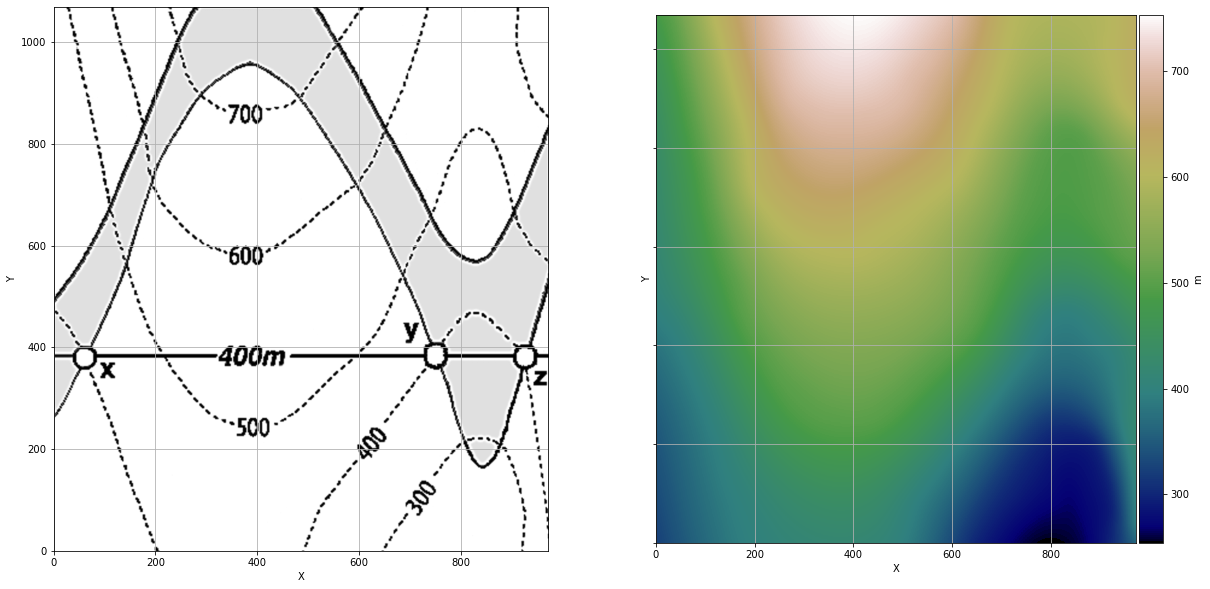

In [5]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
img = ax2.imshow(np.flipud(dem.read(1)), origin = 'lower', cmap ='gist_earth', extent=extent)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img, ax=ax2, cax=cax)
cbar.set_label('m')

## Inspecting the Raster Object

Rasterio objects have different attributes that can easily be accessed. 

In [6]:
dem.crs

CRS.from_dict(init='epsg:4326')

In [7]:
dem.bounds

BoundingBox(left=-4.440892098500626e-16, bottom=1.3642420526593924e-12, right=971.002897605575, top=1068.1031873661339)

In [8]:
dem.width

250

In [9]:
dem.height

275

In [10]:
dem.count

1

In [11]:
dem.transform

Affine(3.8840115904223, 0.0, -4.440892098500626e-16,
       0.0, -3.8840115904223, 1068.1031873661339)

In [12]:
dem.read(1)

array([[482.82904, 485.51953, 488.159  , ..., 618.8612 , 620.4424 ,
        622.05786],
       [481.6521 , 484.32193, 486.93958, ..., 618.8579 , 620.44556,
        622.06714],
       [480.52563, 483.18893, 485.80444, ..., 618.8688 , 620.4622 ,
        622.08923],
       ...,
       [325.49225, 327.21985, 328.94498, ..., 353.6889 , 360.03125,
        366.3984 ],
       [325.0538 , 326.78473, 328.51276, ..., 351.80603, 357.84106,
        363.96167],
       [324.61444, 326.34845, 328.0794 , ..., 350.09247, 355.87598,
        361.78635]], dtype=float32)

<a id='ex2'></a>
# Example 2 - Raster Data - Interpolating Raster Data

As a second example we will have a look at the same geological map as before. Instead of loading a raster, contour lines with attributed height values are used to interpolate a raster. 

For this example we will use the following functions:

- ```gg.interpolate_raster(...)```


<img src="../data/Test1/task1.png" width="300">

## Loading data
The raster data will be loaded as rasterio.io.DataSetReader object. The data is provided in the repository. The coordinate reference system (CRS) is stored within the object which is essential to know when transforming data from one CRS to another. 

In [13]:
topo = gpd.read_file('../../gemgis/data/Test1/topo1.shp')
geological_map = rasterio.open('../../gemgis/data/Test1/task1.tif')

## Defining the working/model area extent

Especially when working with unreferenced numpy.ndarrays, it becomes important provide the extent of these arrays in real world coordinates. The extent can be provided for GemGIS as ```minx, maxx, miny, maxy``` and if a third dimension is available as ```minx, maxx, miny, maxy, minz, maxz```.

In [14]:
extent = gg.set_extent(0,972,0,1069)
extent

[0, 972, 0, 1069]

## Plotting Data

The raster data can now be plotted next to the geological map without any manipulation by using ```plt.imshow(...)```. Bright values indicate high altitudes, dark colors indicate low altitudes. When plotting the raster it is necessary to provide the extent of the raster as defined above. This way, the raster is scaled to the true extent of the geological map. A second important thing is that the height values of the object can be accessed with ```dem.read(1)``` where 1 is equal to the band number of the raster.

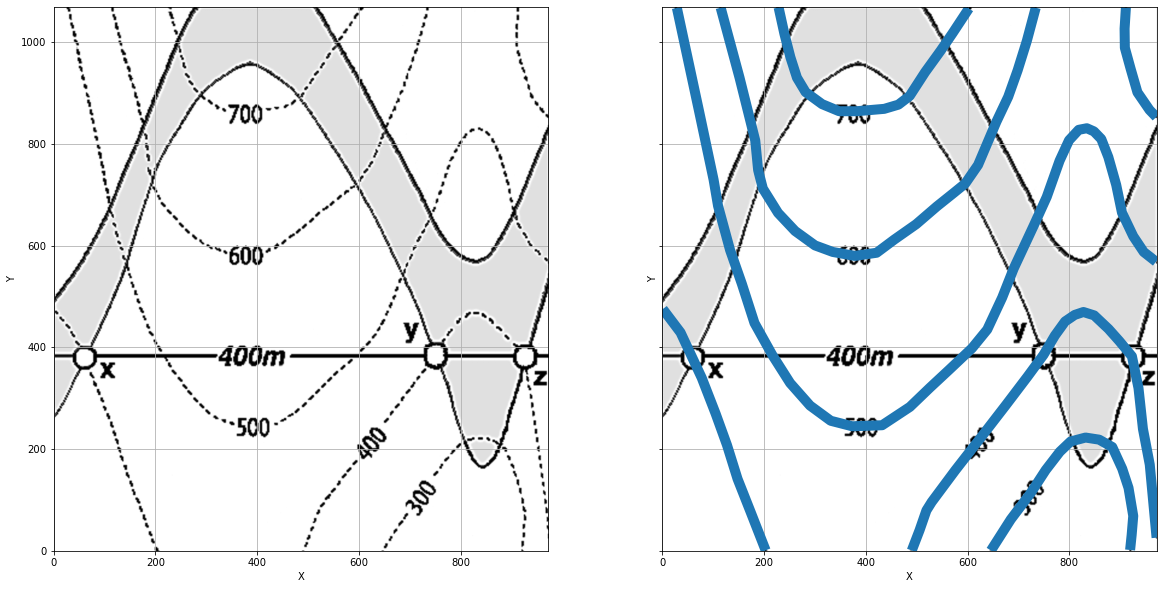

In [15]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the contour lines of the topographic map
topo.plot(ax=ax2, legend = True, linewidth = 10)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Inspecting the GeoDataFrame

Rasterio objects have different attributes that can easily be accessed. 

In [16]:
topo.head()

id    Z                                           geometry
0  None  400  LINESTRING (0.741 475.441, 35.629 429.247, 77....
1  None  300  LINESTRING (645.965 0.525, 685.141 61.866, 724...
2  None  400  LINESTRING (490.292 0.525, 505.756 40.732, 519...
3  None  600  LINESTRING (911.433 1068.585, 908.856 1026.831...
4  None  700  LINESTRING (228.432 1068.585, 239.772 1017.037...

In [17]:
topo.crs

{'init': 'epsg:4326'}

## Interpolating the Raster

Several methods have been implemented into GemGIS. These include the methods ```nearest```, ```cubic``` and ```linear``` of ```scipy.interpolate.griddata``` and ```Rbf``` of ```scipy.interpolate.rbf```. The different methods can be accessed by passing the argument ```method= 'method_name'```.

In [18]:
topo_interpolated = gg.interpolate_raster(topo, method='rbf')
topo_interpolated

array([[411.82014581, 411.69052091, 411.56158939, ..., 384.04962954,
        385.42140506, 386.76248969],
       [411.66101945, 411.5316941 , 411.40306465, ..., 384.4299191 ,
        385.80964238, 387.15718098],
       [411.5023835 , 411.37335931, 411.24503355, ..., 384.8252337 ,
        386.21293421, 387.56684012],
       ...,
       [499.18752484, 499.15158818, 499.11692808, ..., 624.97739453,
        625.38574125, 625.79305697],
       [499.53566482, 499.49887905, 499.4633306 , ..., 625.17315916,
        625.58165735, 625.98912699],
       [499.90110024, 499.86421238, 499.82858152, ..., 625.37307284,
        625.78164892, 626.18920124]])

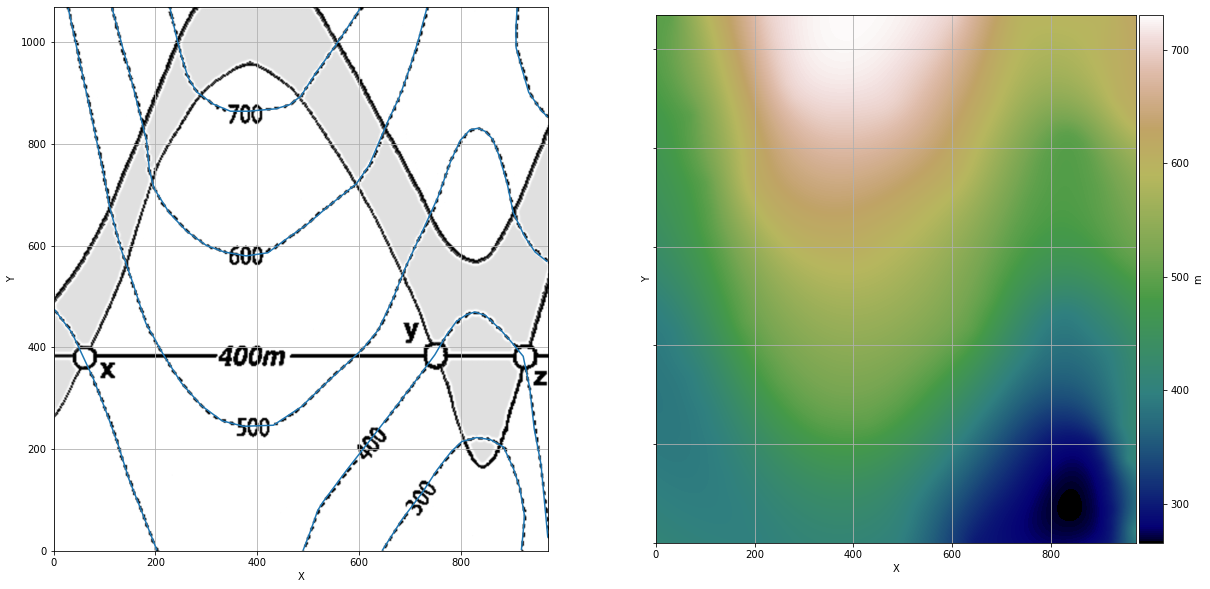

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
topo.plot(ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])
ax1.grid()
img = ax2.imshow(topo_interpolated, origin='lower', cmap = 'gist_earth')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlim(extent[0],extent[1])
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img, ax=ax2, cax=cax)
cbar.set_label('m')

<a id='ex3'></a>
# Example 3 - Raster Data - Calculating slope, aspect and hillshades

As a third example it is shown how to calculate the slope and aspect of a raster which can then be used to obtain orientations (if the raster is a lithological layer) and hillshades to better visualize the raster data. 

## Loading Data

In [20]:
dem = rasterio.open('../../gemgis/data/Test1/raster1.tif')
geological_map = rasterio.open('../../gemgis/data/Test1/task1.tif')

## Defining the working/model area extent

Especially when working with unreferenced numpy.ndarrays, it becomes important to provide the extent of these arrays in real world coordinates. The extent can be provided for GemGIS as ```minx, maxx, miny, maxy``` and if a third dimension is available as ```minx, maxx, miny, maxy, minz, maxz```.

In [21]:
extent = gg.set_extent(0,972,0,1069)
extent

[0, 972, 0, 1069]

## Calculating hillshades

In [22]:
hillshades = gg.calculate_hillshades(dem.read(1))

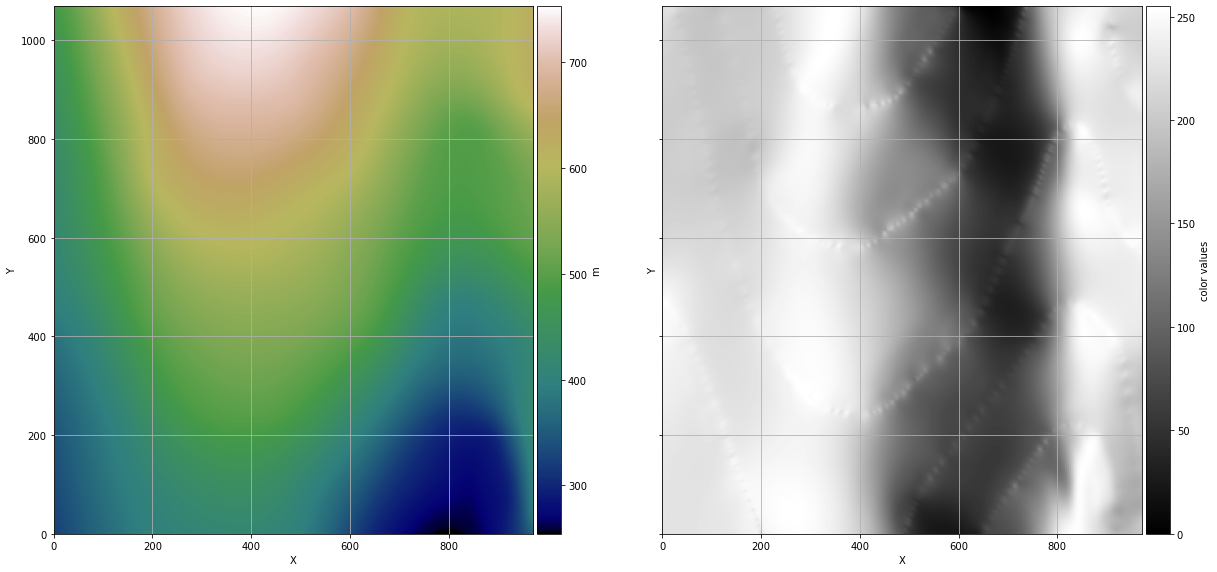

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,10))
arr = ax1.imshow(dem.read(1), cmap = 'gist_earth',extent = extent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])
ax1.grid()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(arr, ax=ax1, cax=cax)
cbar.set_label('m')
hill = ax2.imshow(hillshades,cmap = 'gray',extent = extent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlim(extent[0],extent[1])
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(hill, ax=ax2, cax=cax)
cbar.set_label('color values')

## Claculating slope

In [24]:
slope = gg.calculate_slope(dem.read(1))

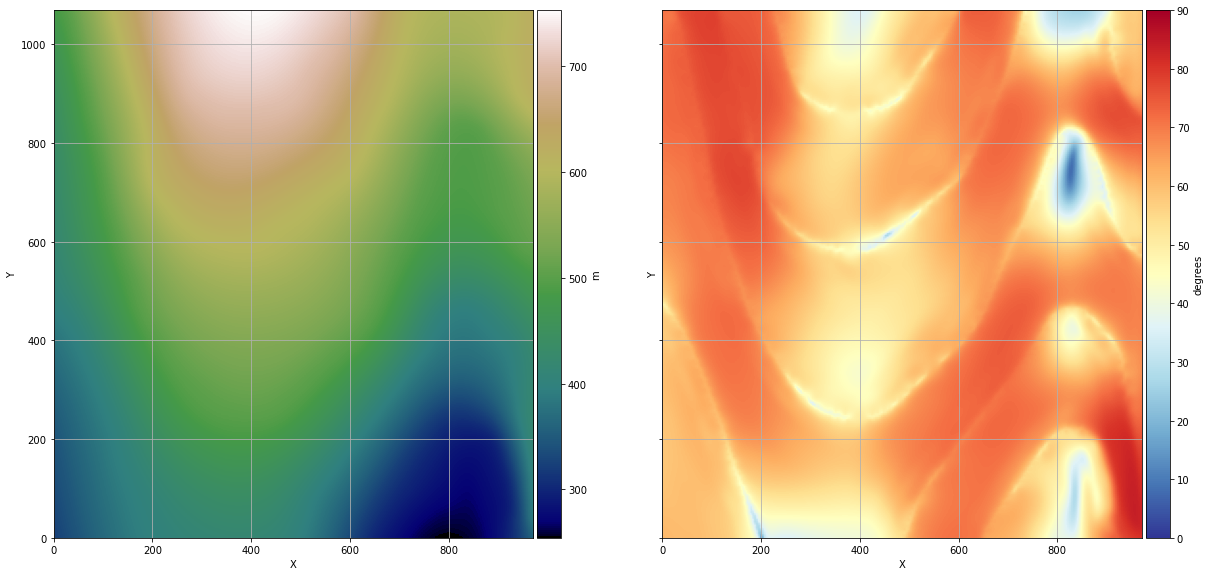

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,10))
arr = ax1.imshow(dem.read(1), cmap = 'gist_earth',extent = extent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])
ax1.grid()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(arr, ax=ax1, cax=cax)
cbar.set_label('m')
slopes = ax2.imshow(slope, cmap = 'RdYlBu_r',extent = extent, vmin=0, vmax= 90)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlim(extent[0],extent[1])
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(slopes, ax=ax2, cax=cax)
cbar.set_label('degrees')

## Calculating Aspect

In [26]:
aspect = gg.calculate_aspect(dem.read(1))

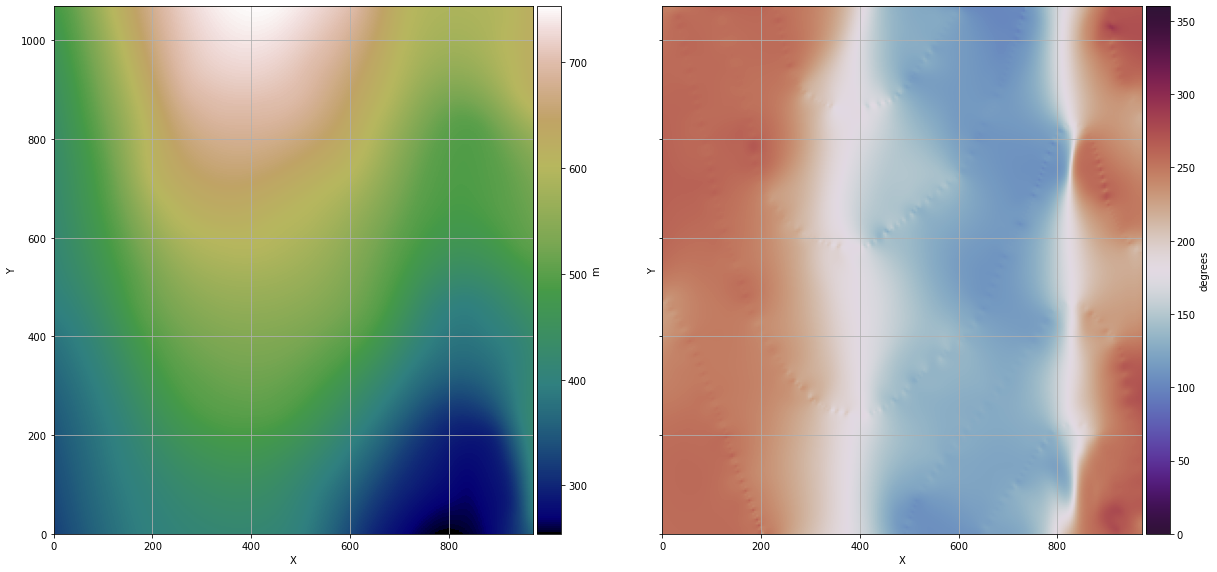

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,10))
arr = ax1.imshow(dem.read(1), cmap = 'gist_earth',extent = extent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])
ax1.grid()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(arr, ax=ax1, cax=cax)
cbar.set_label('m')
asp = ax2.imshow(aspect, cmap = 'twilight_shifted',extent = extent, vmin=0, vmax=360)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlim(extent[0],extent[1])
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(asp, ax=ax2, cax=cax)
cbar.set_label('degrees')

# Example 4 - Raster Data - Sampling from Raster

As a fourth example we are going to sample values from a raster. Sampling height values from a raster was already utilized in the previous notebook. 

## The following functions will be used:
- `gg.sample_from_raster(...)`
- `gg.sample_from_raster_randomly(...)`
- `gg.sample_orientations_from_raster(...)`
- `gg.sample_interfaces_from_raster(...)`

## Defining the working/model area extent

Especially when working with unreferenced numpy.ndarrays, it becomes important to provide the extent of these arrays in real world coordinates. The extent can be provided for GemGIS as ```minx, maxx, miny, maxy``` and if a third dimension is available as ```minx, maxx, miny, maxy, minz, maxz```.

In [28]:
extent = gg.set_extent(0,972,0,1069)
extent

[0, 972, 0, 1069]

## Load Data

In [29]:
dem = rasterio.open('../../gemgis/data/Test1/raster1.tif')
geological_map = rasterio.open('../../gemgis/data/Test1/task1.tif')

## Plot Data

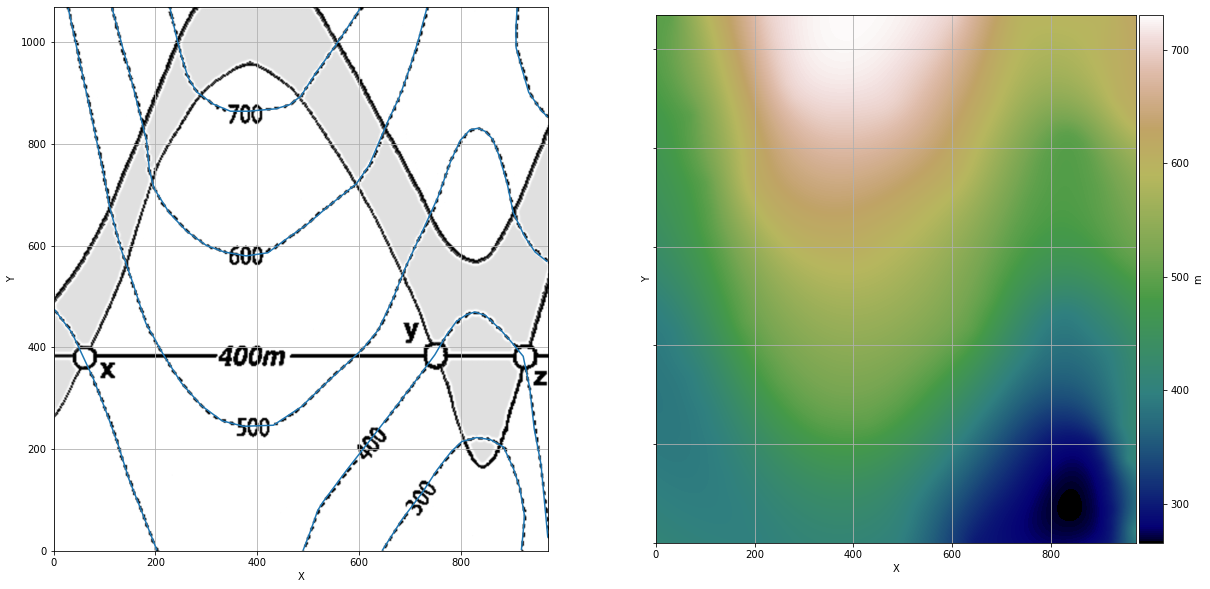

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
topo.plot(ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])
ax1.grid()
img = ax2.imshow(topo_interpolated, origin='lower', cmap = 'gist_earth')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_ylim(extent[2],extent[3])
ax2.set_xlim(extent[0],extent[1])
ax2.grid()
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(img, ax=ax2, cax=cax)
cbar.set_label('m')

## Sample from raster

`gg.sample_from_raster(...)` samples from the provided raster at a given point and returns the raster value at that point.

In [31]:
sample = gg.sample_from_raster(dem.read(1), extent, [500,500])
sample

579.60974

## Sample from raster randomly
`gg.sample_from_raster_randomly(...)` samples from the provided raster at a given point and returns the raster value at that point in addition to the coordinates of the sampled location.

In [32]:
sample = gg.sample_from_raster_randomly(dem.read(1), extent)
sample

(657.8638, [213.69399602851473, 156.66929666694622])

## Sample orientations from raster

`gg.sample_orientations_from_raster(...)` samples from the provided raster at a given locations and returns a DataFrame containing all necessary information.

<div class="alert alert-block alert-warning">
<b>Attention:</b> Sampling orientations from a raster should only be performed if the raster is NOT the digital elevation model but a already constructed subsurface layer!
</div>

In [ ]:
orientations = gg.sample_orientations_from_raster(dem.read(1), extent, formation='surface')
orientations

It is also possible to provide a list of points with locations at which orientation values are being sampled. 

In [34]:
orientations = gg.sample_orientations_from_raster(dem.read(1), extent, points= [500,500],formation='surface')
orientations

X      Y           Z        dip     azimuth  polarity formation
0  500.0  500.0  579.609741  54.845726  139.273026       1.0   surface

In [35]:
orientations = gg.sample_orientations_from_raster(dem.read(1), extent, points= [[500,500], [600,600]],formation='surface')
orientations

X      Y           Z        dip     azimuth  polarity formation
0  500.0  500.0  579.609741  54.845726  139.273026       1.0   surface
1  600.0  600.0  524.915527  60.221336  124.195122       1.0   surface

## Sample interfaces from raster

`gg.sample_interfaces_from_raster(...)` samples from the provided raster at a given locations and returns a DataFrame containing all necessary information.

<div class="alert alert-block alert-warning">
<b>Attention:</b> Sampling interfaces from a raster should only be performed if the raster is NOT the digital elevation model but a already constructed subsurface layer!
</div>

In [36]:
interfaces = gg.sample_interfaces_from_raster(dem.read(1), extent, formation='surface')
interfaces

X           Y           Z formation
0  405.345389  770.026883  515.173645   surface
1    0.111172  323.193520  429.546021   surface
2  142.646726   98.709958  604.455200   surface
3  181.044925  369.404417  582.072754   surface
4  385.657985  575.995089  568.996887   surface
5  407.457068  732.499646  524.695801   surface
6  198.727587  938.707540  416.659698   surface
7   26.620741  716.729768  381.068298   surface
8  405.620268  597.239427  561.270081   surface
9  136.456104  211.770492  565.199097   surface

It is also possible to provide a list of point with locations at which interfaces are being sampled.

In [37]:
interfaces = gg.sample_interfaces_from_raster(dem.read(1), extent, points=[500,500],formation='surface')
interfaces

X      Y           Z formation
0  500.0  500.0  579.609741   surface

In [38]:
interfaces = gg.sample_interfaces_from_raster(dem.read(1), extent, points=[[500,500],[600,600]],formation='surface')
interfaces

X      Y           Z formation
0  500.0  500.0  579.609741   surface
1  600.0  600.0  524.915527   surface

# Clip Raster by Extent

# Clip Raster by Shape

# Save Raster as Tiff

# Additional Manipulation Options

Additional manipulation options for rasters are implemented in the following functions:

- `gg.calculate_difference(...)`
- `gg.rescale_raster(...)`
- `gg.rescale_raster_by_array(...)`

In [39]:
import scooby
scooby.Report(additional=[gpd, rasterio, gg])

--------------------------------------------------------------------------------
  Date: Sat Jul 18 21:35:12 2020 W. Europe Daylight Time

                OS : Windows
            CPU(s) : 24
           Machine : AMD64
      Architecture : 64bit
               RAM : 63.9 GB
       Environment : Jupyter

  Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]

         geopandas : 0.6.1
          rasterio : 1.0.21
            gemgis : Version unknown
             numpy : 1.18.5
             scipy : 1.5.0
           IPython : 7.16.1
        matplotlib : 3.2.2
            scooby : 0.5.2

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------